In [1]:

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import sys

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = T.Compose([ T.ToTensor(),
                        T.Resize(64),
                        T.Normalize([.5,.5,.5],[.5,.5,.5])
                       ])
dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)
batchsize   = 32
data_loader = DataLoader(dataset,batch_size=batchsize,shuffle=True,drop_last=True)

Files already downloaded and verified


In [4]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, color_channels, discriminator_features):
        super(Discriminator, self).__init__()
        self.dis = nn.Sequential(
            
            # Input: (input_channels) x 64 x 64
            nn.Conv2d(color_channels, discriminator_features, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            # State size: (discriminator_features) x 32 x 32
            
            nn.Conv2d(discriminator_features, discriminator_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_features * 2),
            nn.LeakyReLU(0.2),
            # State size: (discriminator_features*2) x 16 x 16
            
            nn.Conv2d(discriminator_features * 2, discriminator_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_features * 4),
            nn.LeakyReLU(0.2),
            # State size: (discriminator_features*4) x 8 x 8
            
            nn.Conv2d(discriminator_features * 4, discriminator_features * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_features * 8),
            nn.LeakyReLU(0.2),
            # State size: (discriminator_features*8) x 4 x 4
            
            nn.Conv2d(discriminator_features * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.dis(input).view(-1)     



class Generator(nn.Module):
    def __init__(self, latent_dim, generator_features, color_channels):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # Input: (latent_dim, 1, 1)
            nn.ConvTranspose2d(latent_dim, generator_features * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(generator_features * 8),
            nn.ReLU(),
            # State: (512, 4, 4)

            nn.ConvTranspose2d(generator_features * 8, generator_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_features * 4),
            nn.ReLU(),
            # State: (256, 8, 8)

            nn.ConvTranspose2d(generator_features * 4, generator_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_features * 2),
            nn.ReLU(),
            # State: (128, 16, 16)

            nn.ConvTranspose2d(generator_features * 2, generator_features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_features),
            nn.ReLU(),
            # State: (64, 32, 32)

            nn.ConvTranspose2d(generator_features, color_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: (3, 64, 64)
        )

    def forward(self, x):
        return self.gen(x)

In [5]:
dnet = Discriminator(3, 64)
y = dnet(torch.randn(10,3,64,64))
y.shape

torch.Size([10])

torch.Size([10, 3, 64, 64])


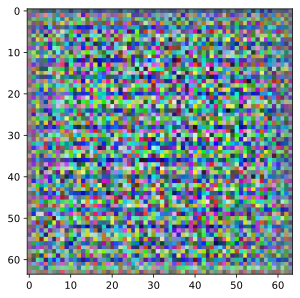

In [6]:
gnet = Generator(100, 64, 3)
y = gnet(torch.randn(10,100,1,1))
print(y.shape)
pic = y[0,:,:,:].squeeze().detach().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
plt.imshow(pic);

In [7]:
gnet = Generator(latent_dim=100, generator_features=64, color_channels=3).to(device)
dnet = Discriminator(color_channels=3, discriminator_features=64).to(device)

g_optim = torch.optim.Adam(gnet.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optim = torch.optim.Adam(dnet.parameters(), lr=0.0002, betas=(0.5, 0.999))

lossFn = nn.BCELoss()

In [8]:
epochs = 15

from tqdm.auto import tqdm

losses  = []
disDecs = []

for epoch in tqdm(range(epochs)):

  for data,_ in data_loader:
    
    data = data.to(device)

    real_labels = torch.ones(batchsize,1).to(device)
    fake_labels = torch.zeros(batchsize,1).to(device)



    pred_real   = dnet(data)
    d_loss_real = lossFn(pred_real, real_labels.squeeze())

    fake_data   = torch.randn(batchsize,100,1,1).to(device)
    fake_images = gnet(fake_data)
    pred_fake   = dnet(fake_images)
    d_loss_fake = lossFn(pred_fake,fake_labels.squeeze())

    d_loss = d_loss_real + d_loss_fake

    # backprop
    d_optim.zero_grad()
    d_loss.backward()
    d_optim.step()


    fake_images = gnet( torch.randn(batchsize,100,1,1).to(device) )
    pred_fake   = dnet(fake_images)

    g_loss = lossFn(pred_fake,real_labels.squeeze())

    g_optim.zero_grad()
    g_loss.backward()
    g_optim.step()


    losses.append([d_loss.item(),g_loss.item()])

    d1 = torch.mean((pred_real>.5).float()).detach()
    d2 = torch.mean((pred_fake>.5).float()).detach()
    disDecs.append([d1,d2])

losses  = np.array(losses)
disDecs = np.array([[d1.cpu().numpy(), d2.cpu().numpy()] for d1, d2 in disDecs])

C:\Users\litwi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [21:18<00:00, 85.21s/it]


In [9]:
def smooth(x,k=15):
  return np.convolve(x,np.ones(k)/k,mode='same')

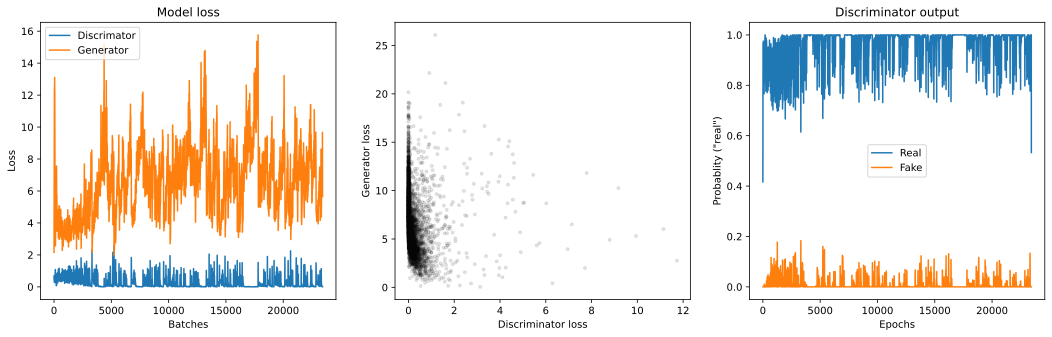

In [10]:
fig,ax = plt.subplots(1,3,figsize=(18,5))
losses  = np.array(losses)
ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([1500,2000])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(disDecs[:,0]))
ax[2].plot(smooth(disDecs[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

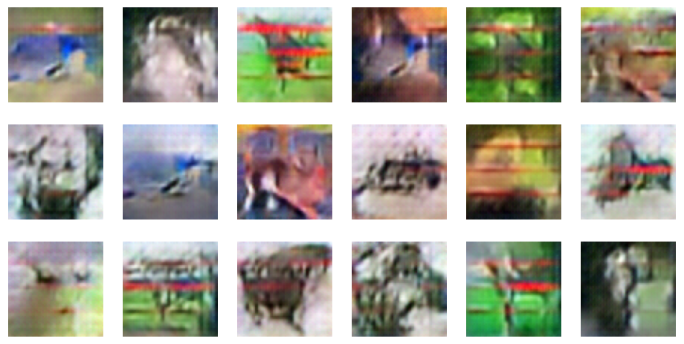

In [11]:

gnet.eval()
fake_data = gnet( torch.randn(batchsize,100,1,1).to(device) ).cpu()

fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  pic = fake_data[i,:,].detach().squeeze().numpy().transpose((1,2,0))
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
  ax.imshow(pic,cmap='gray')
  ax.axis('off')

plt.show()